<a href="https://www.kaggle.com/code/salimhammadi07/geoai-hack-2022-crop-type-classification-challenge?scriptVersionId=103752566" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# GeoAI Hack 2022 Crop Type Classification Challenge


This is a private hackathon open to Tunisia GeoAI Hack 2022 participants. If you are a University Student or a Young Professional and would like to participate, please fill out this form.

With the growth of world population, much more effort and innovation will be urgently needed in order to sustainably increase agricultural production, improve the global supply chain, decrease food waste, and ensure access to nutritious food to all vulnerable people essentially in developing countries and Africa. Sustainable agriculture is related to The Sustainable Development Goal to “End hunger, achieve food security and improve nutrition and promote sustainable agriculture” (SDG2).

In this context, crop type mapping is a major challenge for agricultural and environmental policy makers. The recent growth of open Satellite imagery time series allows large scale crop mapping.

The objective of the challenge is to use Sentinel-2 multispectral time series to classify crops in Central Tunisia, specifically in the Kairouan agricultural region.

The ground truth reference data was collected in the field by the AGEOS Team. The challenge datasets were processed by IEEE Sup'com GRSS Chapter Members.


# 1. Imports

In [1]:
# import numpy for math calculations
import numpy as np

# import pandas for data (csv) manipulation
import pandas as pd

# import matplotlib for plotting
import matplotlib.pyplot as plt

# import seaborn for more plotting options(built on top of matplotlib)
import seaborn as sns

# Supress unnecessary warnings so that the presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# missingno is a  python package especially for visualizing and exploring the missing data of a dataset.
import missingno as msno

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm


# display plots on the notebook itself
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/geoai-hack/SampleSubmission.csv
/kaggle/input/dataset128745/Test (8).csv
/kaggle/input/dataset128745/Train (11).csv


In [2]:
import random 
def seed_everything(seed=42): 
    random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed) 
seed_everything(42)

# 2. Load files


In [3]:
# reading the dataset

train = pd.read_csv('../input/dataset128745/Train (11).csv')
test = pd.read_csv('../input/dataset128745/Test (8).csv')
submission = pd.read_csv('../input/geoai-hack/SampleSubmission.csv', index_col = 0)

test = test.drop(columns=['ID'])
train = train.drop(columns=['ID'])


# checking the shape of the data
test.shape

(502, 1200)

# 3. Preview files

In [4]:
# Check the first five rows of the train set
train.head()

,Target,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,olive+cereals,456.918182,799.361364,825.761364,1420.606818,2478.922727,2882.245455,3084.704545,1989.954545,1250.377273,...,113.0,562.0,206.0,1193.0,1497.0,1588.0,1644.0,2060.0,1157.0,1630.0
1,plowing_and_sowing,1087.130208,1653.770833,2194.458333,2447.984375,2588.328125,2725.609375,2777.385417,3698.088542,2962.229167,...,328.0,913.0,746.0,1468.0,1523.0,1603.0,1782.0,2308.0,1429.0,1741.0
2,olive,917.369369,1383.882883,1742.765766,2012.234234,2388.657658,2592.783784,2644.738739,3111.837838,2456.693694,...,113.0,587.0,312.0,1161.0,2050.0,2182.0,2238.0,2016.0,1134.0,2372.0
3,arable_soil,1013.775120,1551.863636,2073.009569,2371.222488,2666.064593,2843.196172,2930.330144,3802.370813,3152.626794,...,212.0,592.0,810.0,1289.0,1655.0,1796.0,1824.0,2418.0,1708.0,1965.0
4,olive,801.352113,1243.741784,1557.410798,1827.133803,2248.718310,2433.793427,2471.901408,2846.659624,2175.328638,...,84.0,326.0,480.0,790.0,1132.0,1207.0,1194.0,1595.0,1085.0,1283.0


In [5]:
# Check the first five rows of the test set
test.head()

,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,timestep1_B12_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,901.974359,1255.743590,1561.230769,1891.230769,2340.333333,2568.282051,2679.179487,3381.820513,2856.641026,2736.923077,...,345.0,631.0,763.0,1299.0,1803.0,1964.0,2050.0,2384.0,1901.0,2171.0
1,927.181818,1423.636364,1778.636364,2161.477273,2745.909091,2969.204545,3063.000000,3632.977273,2942.500000,3086.863636,...,600.0,1048.0,1416.0,2014.0,2367.0,2574.0,2614.0,3160.0,2482.0,2795.0
2,716.611940,1126.828358,1390.171642,1751.037313,2480.328358,2757.880597,2798.059701,2913.335821,2234.589552,2868.097015,...,228.0,525.0,723.0,1106.0,1514.0,1582.0,1742.0,2141.0,1453.0,1761.0
3,565.611940,931.238806,999.813433,1558.462687,2627.276119,2965.738806,3134.194030,2584.865672,1740.194030,3202.037313,...,245.0,528.0,723.0,1140.0,1270.0,1420.0,1532.0,2270.0,1387.0,1613.0
4,943.473430,1371.809179,1709.190821,1926.652174,2180.309179,2325.961353,2378.082126,2846.335749,2323.219807,2412.541063,...,415.0,840.0,1046.0,1417.0,1885.0,2017.0,2080.0,2375.0,1665.0,2157.0


# 4. Data exploration

<AxesSubplot:xlabel='Target', ylabel='count'>

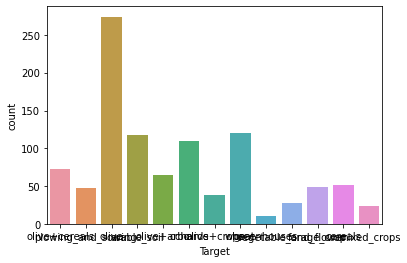

In [6]:
sns.countplot(train['Target'])

In [7]:
train['Target'].value_counts()

olive                   274
wheat                   120
arable_soil             117
ochards                 110
olive+cereals            72
olive+arbo               65
cereals                  51
forage_crop              49
plowing_and_sowing       47
olive+crops              38
vegetable_and_flower     27
mixed_crops              24
greenhouses              10
Name: Target, dtype: int64

In [8]:
# Check statistical summaries of the train set
train.describe()

,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,timestep1_B12_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,...,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,826.039380,1264.823679,1534.559069,1938.815380,2600.636295,2876.932359,2985.834547,3108.420655,2429.938561,3037.425322,...,246.202191,595.307769,680.809761,1175.660359,1731.605578,1918.469124,1900.181275,2080.300797,1400.980080,2073.429283
std,230.938070,301.210832,449.509855,391.125007,319.494496,365.617453,381.314622,656.239914,711.705271,373.184252,...,150.807854,226.128357,317.532936,322.044282,365.242186,397.252290,420.311209,468.923122,411.853348,428.892306
min,302.281967,516.475410,451.638681,874.668852,1701.291000,1917.047000,2103.804000,1526.881967,841.216393,2188.208861,...,1.000000,1.000000,1.000000,162.000000,598.000000,717.000000,487.000000,738.000000,403.000000,866.000000
25%,661.045366,1065.455652,1203.959027,1675.447539,2377.109819,2611.862069,2712.871902,2679.632851,1932.788922,2773.953600,...,133.000000,439.000000,425.000000,966.000000,1478.000000,1657.750000,1619.000000,1752.750000,1101.000000,1792.000000
50%,836.687820,1270.350129,1567.916329,1931.730284,2580.648079,2843.169515,2957.031598,3090.900817,2424.754991,3008.658642,...,241.000000,595.000000,669.000000,1168.500000,1708.000000,1913.500000,1903.000000,2051.000000,1366.000000,2075.000000
75%,976.447704,1456.784870,1845.849055,2183.467727,2793.607472,3110.279579,3226.978689,3589.716780,2936.175417,3266.150835,...,352.000000,752.000000,917.250000,1382.250000,1981.750000,2191.250000,2190.500000,2393.250000,1643.250000,2379.250000
max,1787.730496,2503.418440,3209.107438,3587.349862,3981.695312,4617.163636,4773.290909,5364.127640,5032.491276,4727.245455,...,933.000000,1676.000000,1964.000000,2645.000000,3033.000000,3296.000000,3186.000000,3700.000000,2988.000000,3425.000000


In [9]:
# Check for any missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [10]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

In [11]:
def most_correlated(dataframe):
    """
    Returns a dataframe that contains the most correlated features
    
    dataframe: dataframe that gives the column names and their correlation value
    """
    corr_values = dataframe.abs().unstack()
    sorted_values = pd.DataFrame(corr_values.sort_values(kind="quicksort"), index= None)
    sorted_values = sorted_values[(sorted_values[0] > 0.4) & (sorted_values[0] < 1)]
    return sorted_values.drop_duplicates()
most_correlated(train.corr())

,,0
timestep12_B11_std,timestep14_B07_max,0.400001
timestep13_B07_std,timestep19_B06_max,0.400003
timestep11_B07_min,timestep13_B05_min,0.400003
timestep2_B8A_std,timestep22_B04_std,0.400004
timestep20_B11_max,timestep1_B03_std,0.400008
...,...,...
timestep15_B08_mean,timestep15_B12_mean,0.998458
timestep5_B12_mean,timestep5_B08_mean,0.998505
timestep3_B12_mean,timestep3_B08_mean,0.998521
timestep18_B08_mean,timestep18_B12_mean,0.998522


# 5. Features Engineering

In [12]:
in_cols = train.filter(like='timestep1_').columns.tolist()
col_names = [x[9:] for x in in_cols]

In [13]:
n = train.shape[0]
target_mapper = dict(zip(submission.columns.tolist(),[i for i in range(len(submission.columns.tolist()))]))
Inversetarget_mapper = dict(zip([i for i in range(len(submission.columns.tolist()))],submission.columns.tolist()))
train['Target'] = train['Target'].map(target_mapper)

In [14]:
def process(dataframe):        
    for i in range(1,25):
        # ------- mean ------
        dataframe['mean_vegitation_index_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B04_mean'] ) / (dataframe['timestep'+str(i)+'_B08_mean'] + dataframe['timestep'+str(i)+'_B04_mean'] )
        dataframe['mean_Moisture_index_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B8A_mean'] - dataframe['timestep'+str(i)+'_B11_mean'] ) / (dataframe['timestep'+str(i)+'_B8A_mean'] + dataframe['timestep'+str(i)+'_B11_mean'] )
    
        dataframe['mean_GNDVI_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B03_mean'] ) / (dataframe['timestep'+str(i)+'_B08_mean'] + dataframe['timestep'+str(i)+'_B03_mean'] )
        dataframe['mean_EVI_timestep'+str(i)]= (0.25* (dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B04_mean'] ) )/ (dataframe['timestep'+str(i)+'_B08_mean'] * 6* dataframe['timestep'+str(i)+'_B04_mean']*dataframe['timestep'+str(i)+'_B02_mean'] + 1 )
        dataframe['mean_RVI_timestep'+str(i)]= dataframe['timestep'+str(i)+'_B04_mean']/ dataframe['timestep'+str(i)+'_B08_mean']
        dataframe['mean_GVRI_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B03_mean'] - dataframe['timestep'+str(i)+'_B04_mean'] ) / (dataframe['timestep'+str(i)+'_B03_mean'] + dataframe['timestep'+str(i)+'_B04_mean'] )
        dataframe['mean_NBR_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B8A_mean'] - dataframe['timestep'+str(i)+'_B12_mean'] ) / (dataframe['timestep'+str(i)+'_B8A_mean'] + dataframe['timestep'+str(i)+'_B12_mean'] )
        
        dataframe['mean_CVI_timestep'+str(i)]= ( dataframe['timestep'+str(i)+'_B08_mean']/ dataframe['timestep'+str(i)+'_B03_mean'] ) * ( dataframe['timestep'+str(i)+'_B04_mean']/ dataframe['timestep'+str(i)+'_B03_mean'] )
        dataframe['mean_AVI_timestep'+str(i)]= dataframe['timestep'+str(i)+'_B08_mean']* ( 1 - dataframe['timestep'+str(i)+'_B04_mean'] ) * ( dataframe['timestep'+str(i)+'_B08_mean'] -  dataframe['timestep'+str(i)+'_B04_mean'] )
        dataframe['mean_SI_timestep'+str(i)]= ( 1 - dataframe['timestep'+str(i)+'_B02_mean'] ) * ( 1 - dataframe['timestep'+str(i)+'_B04_mean'] )* ( 1 - dataframe['timestep'+str(i)+'_B03_mean'] )
        
        dataframe['mean_SAVI_timestep'+str(i)]= (1 + 0.33) * ((dataframe['timestep'+str(i)+'_B08_mean'] -  dataframe['timestep'+str(i)+'_B04_mean']) / (dataframe['timestep'+str(i)+'_B08_mean'] +0.33+  dataframe['timestep'+str(i)+'_B04_mean']))
        
        # WINE GRAPES
        dataframe['mean_FIDET_timestep'+str(i)] = dataframe['timestep'+str(i)+'_B12_mean'] / (dataframe['timestep'+str(i)+'_B8A_mean'] * dataframe['timestep'+str(i)+'_B8A_mean'])
        dataframe['mean_MTCI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B06_mean'] - dataframe['timestep'+str(i)+'_B05_mean'])/(dataframe['timestep'+str(i)+'_B05_mean'] - dataframe['timestep'+str(i)+'_B04_mean'])
        dataframe['mean_NPCRI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B04_mean'] - dataframe['timestep'+str(i)+'_B02_mean']) / (dataframe['timestep'+str(i)+'_B04_mean'] + dataframe['timestep'+str(i)+'_B02_mean'])

        # GREENNESS
        dataframe['mean_S2REP_timestep'+str(i)] = 705 + 35 * ((((dataframe['timestep'+str(i)+'_B07_mean'] + dataframe['timestep'+str(i)+'_B04_mean'])/2) - dataframe['timestep'+str(i)+'_B05_mean'])/(dataframe['timestep'+str(i)+'_B06_mean'] - dataframe['timestep'+str(i)+'_B05_mean'])) 
        dataframe['mean_CCCI_timestep'+str(i)] = ((dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B05_mean']) / (dataframe['timestep'+str(i)+'_B08_mean'] + dataframe['timestep'+str(i)+'_B05_mean'])) / ((dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B04_mean']) / (dataframe['timestep'+str(i)+'_B08_mean'] + dataframe['timestep'+str(i)+'_B04_mean'])) 
        dataframe['mean_MCARI_timestep'+str(i)] = ((dataframe['timestep'+str(i)+'_B05_mean'] - dataframe['timestep'+str(i)+'_B04_mean']) - 2 * (dataframe['timestep'+str(i)+'_B05_mean'] - dataframe['timestep'+str(i)+'_B03_mean'])) * (dataframe['timestep'+str(i)+'_B05_mean'] / dataframe['timestep'+str(i)+'_B04_mean'])  
        dataframe['mean_TCARI_timestep'+str(i)] = 3 * ((dataframe['timestep'+str(i)+'_B05_mean'] - dataframe['timestep'+str(i)+'_B04_mean']) - 0.2 * (dataframe['timestep'+str(i)+'_B05_mean'] - dataframe['timestep'+str(i)+'_B03_mean']) * (dataframe['timestep'+str(i)+'_B05_mean'] / dataframe['timestep'+str(i)+'_B04_mean'])) 
        dataframe['mean_PVI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_mean'] - 0.3 * dataframe['timestep'+str(i)+'_B04_mean'] - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 

        # ROOIBOS
        dataframe['mean_BAI_timestep'+str(i)] = 1/((0.1 - dataframe['timestep'+str(i)+'_B04_mean']) ** 2 + (0.06 - dataframe['timestep'+str(i)+'_B08_mean']) ** 2)
        dataframe['mean_MTVI2_timestep'+str(i)] = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(dataframe['timestep'+str(i)+'_B08_mean'], dataframe['timestep'+str(i)+'_B03_mean'], dataframe['timestep'+str(i)+'_B04_mean']))
        dataframe['mean_NDSI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B03_mean'] - dataframe['timestep'+str(i)+'_B11_mean']) / (dataframe['timestep'+str(i)+'_B03_mean'] + dataframe['timestep'+str(i)+'_B11_mean'])

        # RED EDGE
        dataframe['mean_NDVIre_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B05_mean'])/(dataframe['timestep'+str(i)+'_B08_mean'] + dataframe['timestep'+str(i)+'_B05_mean'])
        dataframe['mean_CIre_timestep'+str(i)] = ((dataframe['timestep'+str(i)+'_B08_mean'] / dataframe['timestep'+str(i)+'_B05_mean']) - 1)

        # DRYNESS / DROUGHT
        dataframe['mean_NDMI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B11_mean'])/(dataframe['timestep'+str(i)+'_B08_mean'] + dataframe['timestep'+str(i)+'_B11_mean']) 
        dataframe['mean_TNDVI_timestep'+str(i)] = [(x)**(1/2.0) for x in ((dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B04_mean']) / (dataframe['timestep'+str(i)+'_B08_mean'] + dataframe['timestep'+str(i)+'_B04_mean']) + 0.5)]

        # BASED ON THE VISIBLE SPECTRA REGION
        dataframe['mean_VDVI_timestep'+str(i)] = (2 * dataframe['timestep'+str(i)+'_B03_mean'] - dataframe['timestep'+str(i)+'_B04_mean'] - dataframe['timestep'+str(i)+'_B02_mean']) / (2 * dataframe['timestep'+str(i)+'_B03_mean'] + dataframe['timestep'+str(i)+'_B04_mean']  + dataframe['timestep'+str(i)+'_B02_mean'])
        
        # BURN
        dataframe['mean_NBR_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_mean'] - dataframe['timestep'+str(i)+'_B11_mean']) / (dataframe['timestep'+str(i)+'_B08_mean']+ dataframe['timestep'+str(i)+'_B11_mean']) 
        
        # GENERAL
        dataframe['mean_TVI_timestep'+str(i)] = (120 * (dataframe['timestep'+str(i)+'_B06_mean'] - dataframe['timestep'+str(i)+'_B03_mean']) - 200 * (dataframe['timestep'+str(i)+'_B04_mean'] - dataframe['timestep'+str(i)+'_B03_mean'])) / 2
        dataframe['mean_EXG_timestep'+str(i)] = 2 * dataframe['timestep'+str(i)+'_B03_mean'] - dataframe['timestep'+str(i)+'_B04_mean'] - dataframe['timestep'+str(i)+'_B02_mean']
        dataframe['mean_PSRI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B04_mean'] - dataframe['timestep'+str(i)+'_B02_mean']) / dataframe['timestep'+str(i)+'_B06_mean']
        dataframe['mean_RDVI_timestep'+str(i)] = [(i - j) / (i + j)**(1/2.0) for i, j in zip(dataframe['timestep'+str(i)+'_B08_mean'], dataframe['timestep'+str(i)+'_B04_mean'])]
        
        # COMMON BAND RATIOS

        dataframe['mean_RATIO3_timestep'+str(i)] = dataframe['timestep'+str(i)+'_B11_mean'] / dataframe['timestep'+str(i)+'_B12_mean']
        dataframe['mean_RATIO4_timestep'+str(i)] = dataframe['timestep'+str(i)+'_B05_mean'] / dataframe['timestep'+str(i)+'_B04_mean']

        # --------- Media ------------
        
        dataframe['median_vegitation_index_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B04_median'] ) / (dataframe['timestep'+str(i)+'_B08_median'] + dataframe['timestep'+str(i)+'_B04_median'] )
        dataframe['median_Moisture_index_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B8A_median'] - dataframe['timestep'+str(i)+'_B11_median'] ) / (dataframe['timestep'+str(i)+'_B8A_median'] + dataframe['timestep'+str(i)+'_B11_median'] )
        
        dataframe['median_GNDVI_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B03_median'] ) / (dataframe['timestep'+str(i)+'_B08_median'] + dataframe['timestep'+str(i)+'_B03_median'] )
        dataframe['median_EVI_timestep'+str(i)]= (0.25* (dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B04_median'] ) )/ (dataframe['timestep'+str(i)+'_B08_median'] * 6* dataframe['timestep'+str(i)+'_B04_median']*dataframe['timestep'+str(i)+'_B02_median'] + 1 )
        
        dataframe['median_RVI_timestep'+str(i)]= dataframe['timestep'+str(i)+'_B04_median']/ dataframe['timestep'+str(i)+'_B08_median']
        dataframe['median_GVRI_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B03_median'] - dataframe['timestep'+str(i)+'_B04_median'] ) / (dataframe['timestep'+str(i)+'_B03_median'] + dataframe['timestep'+str(i)+'_B04_median'] )
        dataframe['median_NBR_timestep'+str(i)]= (dataframe['timestep'+str(i)+'_B8A_median'] - dataframe['timestep'+str(i)+'_B12_median'] ) / (dataframe['timestep'+str(i)+'_B8A_median'] + dataframe['timestep'+str(i)+'_B12_median'] )
        
        
        dataframe['median_CVI_timestep'+str(i)]= ( dataframe['timestep'+str(i)+'_B08_median']/ dataframe['timestep'+str(i)+'_B03_median'] ) * ( dataframe['timestep'+str(i)+'_B04_median']/ dataframe['timestep'+str(i)+'_B03_median'] )
        dataframe['median_AVI_timestep'+str(i)]= dataframe['timestep'+str(i)+'_B08_median']* ( 1 - dataframe['timestep'+str(i)+'_B04_median'] ) * ( dataframe['timestep'+str(i)+'_B08_median'] -  dataframe['timestep'+str(i)+'_B04_median'] )
        dataframe['median_SI_timestep'+str(i)]= ( 1 - dataframe['timestep'+str(i)+'_B02_median'] ) * ( 1 - dataframe['timestep'+str(i)+'_B04_median'] )* ( 1 - dataframe['timestep'+str(i)+'_B03_median'] )
        
        dataframe['median_SAVI_timestep'+str(i)]= (1 + 0.33) * ((dataframe['timestep'+str(i)+'_B08_median'] -  dataframe['timestep'+str(i)+'_B04_median']) / (dataframe['timestep'+str(i)+'_B08_median'] +0.33+  dataframe['timestep'+str(i)+'_B04_median']))
        
        # WINE GRAPES
        dataframe['median_FIDET_timestep'+str(i)] = dataframe['timestep'+str(i)+'_B12_median'] / (dataframe['timestep'+str(i)+'_B8A_median'] * dataframe['timestep'+str(i)+'_B8A_median'])
        dataframe['median_MTCI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B06_median'] - dataframe['timestep'+str(i)+'_B05_median'])/(dataframe['timestep'+str(i)+'_B05_median'] - dataframe['timestep'+str(i)+'_B04_median'])
        dataframe['median_NPCRI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B04_median'] - dataframe['timestep'+str(i)+'_B02_median']) / (dataframe['timestep'+str(i)+'_B04_median'] + dataframe['timestep'+str(i)+'_B02_median'])

        # GREENNESS
        dataframe['median_S2REP_timestep'+str(i)] = 705 + 35 * ((((dataframe['timestep'+str(i)+'_B07_median'] + dataframe['timestep'+str(i)+'_B04_median'])/2) - dataframe['timestep'+str(i)+'_B05_median'])/(dataframe['timestep'+str(i)+'_B06_median'] - dataframe['timestep'+str(i)+'_B05_median'])) 
        dataframe['median_CCCI_timestep'+str(i)] = ((dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B05_median']) / (dataframe['timestep'+str(i)+'_B08_median'] + dataframe['timestep'+str(i)+'_B05_median'])) / ((dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B04_median']) / (dataframe['timestep'+str(i)+'_B08_median'] + dataframe['timestep'+str(i)+'_B04_median'])) 
        dataframe['median_MCARI_timestep'+str(i)] = ((dataframe['timestep'+str(i)+'_B05_median'] - dataframe['timestep'+str(i)+'_B04_median']) - 2 * (dataframe['timestep'+str(i)+'_B05_median'] - dataframe['timestep'+str(i)+'_B03_median'])) * (dataframe['timestep'+str(i)+'_B05_median'] / dataframe['timestep'+str(i)+'_B04_median'])  
        dataframe['median_TCARI_timestep'+str(i)] = 3 * ((dataframe['timestep'+str(i)+'_B05_median'] - dataframe['timestep'+str(i)+'_B04_median']) - 0.2 * (dataframe['timestep'+str(i)+'_B05_median'] - dataframe['timestep'+str(i)+'_B03_median']) * (dataframe['timestep'+str(i)+'_B05_median'] / dataframe['timestep'+str(i)+'_B04_median'])) 
        dataframe['median_PVI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_median'] - 0.3 * dataframe['timestep'+str(i)+'_B04_median'] - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 

        # ROOIBOS
        dataframe['median_BAI_timestep'+str(i)] = 1/((0.1 - dataframe['timestep'+str(i)+'_B04_median']) ** 2 + (0.06 - dataframe['timestep'+str(i)+'_B08_median']) ** 2)
        dataframe['median_MTVI2_timestep'+str(i)] = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(dataframe['timestep'+str(i)+'_B08_median'], dataframe['timestep'+str(i)+'_B03_median'], dataframe['timestep'+str(i)+'_B04_median']))
        dataframe['median_NDSI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B03_median'] - dataframe['timestep'+str(i)+'_B11_median']) / (dataframe['timestep'+str(i)+'_B03_median'] + dataframe['timestep'+str(i)+'_B11_median'])

        # RED EDGE
        dataframe['median_NDVIre_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B05_median'])/(dataframe['timestep'+str(i)+'_B08_median'] + dataframe['timestep'+str(i)+'_B05_median'])
        dataframe['median_CIre_timestep'+str(i)] = ((dataframe['timestep'+str(i)+'_B08_median'] / dataframe['timestep'+str(i)+'_B05_median']) - 1)

        # DRYNESS / DROUGHT
        dataframe['median_NDMI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B11_median'])/(dataframe['timestep'+str(i)+'_B08_median'] + dataframe['timestep'+str(i)+'_B11_median']) 
        dataframe['median_TNDVI_timestep'+str(i)] = [(x)**(1/2.0) for x in ((dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B04_median']) / (dataframe['timestep'+str(i)+'_B08_median'] + dataframe['timestep'+str(i)+'_B04_median']) + 0.5)]

        # BASED ON THE VISIBLE SPECTRA REGION
        dataframe['median_VDVI_timestep'+str(i)] = (2 * dataframe['timestep'+str(i)+'_B03_median'] - dataframe['timestep'+str(i)+'_B04_median'] - dataframe['timestep'+str(i)+'_B02_median']) / (2 * dataframe['timestep'+str(i)+'_B03_median'] + dataframe['timestep'+str(i)+'_B04_median']  + dataframe['timestep'+str(i)+'_B02_median'])
        
         # BURN
        dataframe['median_NBR_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B08_median'] - dataframe['timestep'+str(i)+'_B11_median']) / (dataframe['timestep'+str(i)+'_B08_median']+ dataframe['timestep'+str(i)+'_B11_median']) 
        
        # GENERAL
        dataframe['median_TVI_timestep'+str(i)] = (120 * (dataframe['timestep'+str(i)+'_B06_median'] - dataframe['timestep'+str(i)+'_B03_median']) - 200 * (dataframe['timestep'+str(i)+'_B04_median'] - dataframe['timestep'+str(i)+'_B03_median'])) / 2
        dataframe['median_EXG_timestep'+str(i)] = 2 * dataframe['timestep'+str(i)+'_B03_median'] - dataframe['timestep'+str(i)+'_B04_median'] - dataframe['timestep'+str(i)+'_B02_median']
        dataframe['median_PSRI_timestep'+str(i)] = (dataframe['timestep'+str(i)+'_B04_median'] - dataframe['timestep'+str(i)+'_B02_median']) / dataframe['timestep'+str(i)+'_B06_median']
        dataframe['median_RDVI_timestep'+str(i)] = [(i - j) / (i + j)**(1/2.0) for i, j in zip(dataframe['timestep'+str(i)+'_B08_median'], dataframe['timestep'+str(i)+'_B04_median'])]
        
        # COMMON BAND RATIOS

        dataframe['median_RATIO3_timestep'+str(i)] = dataframe['timestep'+str(i)+'_B11_median'] / dataframe['timestep'+str(i)+'_B12_median']
        dataframe['median_RATIO4_timestep'+str(i)] = dataframe['timestep'+str(i)+'_B05_median'] / dataframe['timestep'+str(i)+'_B04_median']
        
        
    for i in range(1,25):
        
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B02_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B03_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B04_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B05_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B06_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B07_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B08_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B8A_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B11_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B12_max'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B02_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B03_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B04_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B05_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B06_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B07_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B08_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B8A_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B11_std'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B12_std'])
        
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B02_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B03_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B04_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B05_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B06_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B07_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B08_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B8A_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B11_mean'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B12_mean'])
        
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B02_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B03_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B04_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B05_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B06_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B07_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B08_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B8A_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B11_median'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B12_median'])
        
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B02_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B03_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B04_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B05_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B06_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B07_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B08_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B8A_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B11_min'])
        dataframe =  dataframe.drop(columns = ['timestep'+str(i)+'_B12_min'])
        

    return dataframe
train = process(train)
test = process(test)


In [15]:
train.corr()['Target'].sort_values( ascending = False).head(50)

Target                     1.000000
mean_S2REP_timestep15      0.435760
median_S2REP_timestep15    0.419029
mean_CCCI_timestep15       0.410825
mean_S2REP_timestep3       0.404909
mean_S2REP_timestep17      0.399320
median_EVI_timestep3       0.394357
mean_S2REP_timestep18      0.392988
median_FIDET_timestep15    0.392194
median_EVI_timestep15      0.389515
mean_CVI_timestep15        0.383394
mean_FIDET_timestep15      0.383171
mean_MTCI_timestep15       0.382821
mean_NPCRI_timestep4       0.382445
median_CVI_timestep15      0.379154
mean_EVI_timestep3         0.377262
median_MCARI_timestep17    0.376530
mean_NPCRI_timestep19      0.375957
mean_CVI_timestep3         0.375346
median_MTCI_timestep15     0.375141
median_CIre_timestep15     0.375022
mean_MCARI_timestep17      0.373315
median_S2REP_timestep3     0.373296
mean_CCCI_timestep17       0.371813
median_CCCI_timestep15     0.371174
median_FIDET_timestep3     0.370975
median_CVI_timestep3       0.370230
mean_CIre_timestep15       0

# 6. Model Building

In [16]:
X = train.loc[:, train.columns != 'Target' ]
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.fillna(0)
test.replace([np.inf, -np.inf], np.nan, inplace=True)
test = test.fillna(0)
y = train.Target

In [17]:
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score

In [18]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_over, y_over = sm.fit_resample(X, y)
X_resampled = pd.DataFrame(X_over, columns=X.columns)
y_resampled = pd.DataFrame(y_over, columns=['Target'])

In [19]:
errcb2=[]
y_pred_totcb2=[]

fold=StratifiedKFold(n_splits=5)
i=1
for train_index, test_index in fold.split(X_resampled,y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    
    m2 = RandomForestClassifier(random_state=0, bootstrap = True, max_depth = 400, n_estimators =1700) # Create the model
    m2.fit(X_train, y_train)
    
    
    preds=m2.predict_proba(X_test)
    print("Accuracy: ",(accuracy_score(y_test,m2.predict(X_test))))
    print('log_loss:',log_loss(y_test,m2.predict_proba(X_test)))
    errcb2.append((accuracy_score(y_test,m2.predict(X_test))))
    p2 = m2.predict_proba(test)
    y_pred_totcb2.append(p2)
np.mean(errcb2)

Accuracy:  0.8779803646563815
log_loss: 0.5864449078056182
Accuracy:  0.8990182328190743
log_loss: 0.5438881932968745
Accuracy:  0.9283707865168539
log_loss: 0.47412492256510824
Accuracy:  0.9213483146067416
log_loss: 0.503600474471755
Accuracy:  0.9157303370786517
log_loss: 0.4882763500707735


0.9084896071355406

# 7. Feature importance

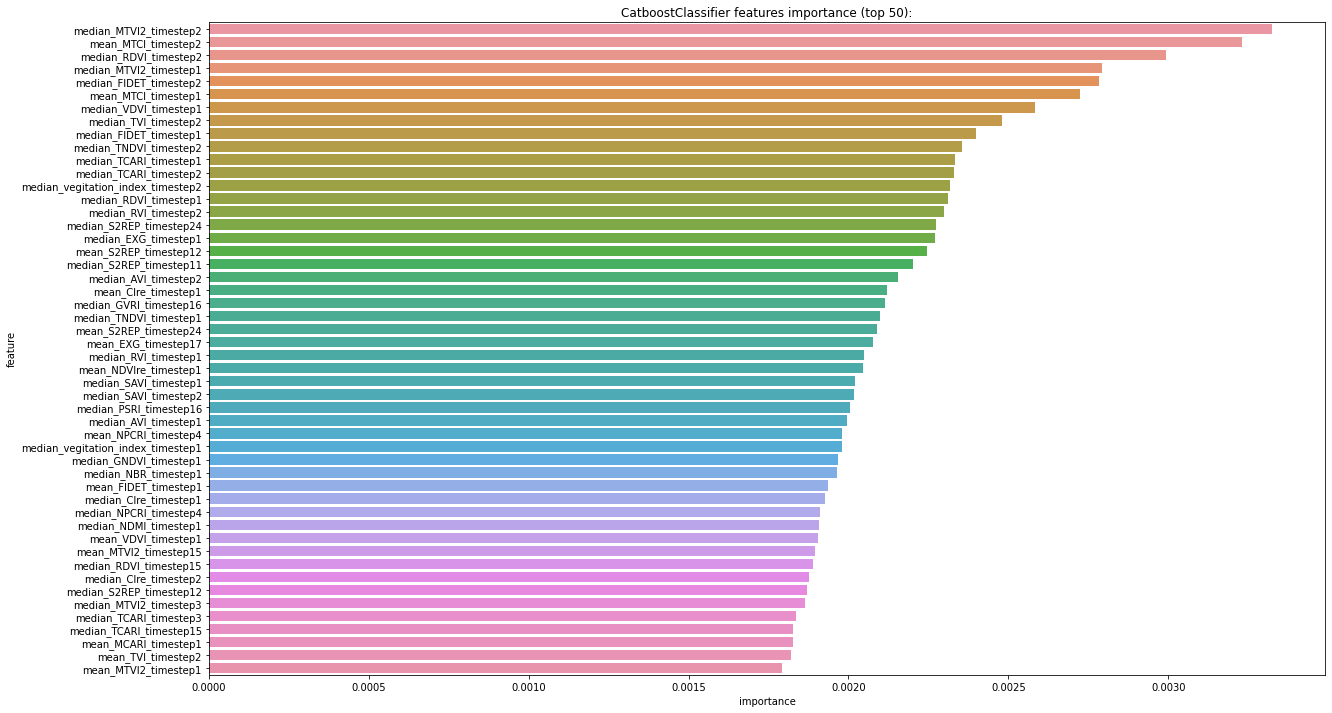

In [20]:
feature_importance_df = pd.DataFrame(m2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('CatboostClassifier features importance (top 50):');

# 8. Submission

---



In [21]:
pd.DataFrame(y_pred_totcb2[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.150588,0.004118,0.054706,0.003529,0.071765,0.051176,0.385294,0.130000,0.061176,0.030588,0.000000,0.049412,0.007647
1,0.055882,0.014118,0.020588,0.041765,0.072941,0.168235,0.103529,0.221176,0.097647,0.129412,0.022353,0.042941,0.009412
2,0.015294,0.026471,0.026471,0.033529,0.159412,0.544706,0.032941,0.040588,0.011176,0.059412,0.016471,0.028235,0.005294
3,0.008824,0.024118,0.030000,0.001765,0.158824,0.160588,0.077647,0.098824,0.115882,0.211765,0.015882,0.072941,0.022941
4,0.081176,0.157647,0.094118,0.097647,0.049412,0.019412,0.075294,0.014706,0.068824,0.004706,0.237059,0.002353,0.097647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.081176,0.040588,0.057059,0.004118,0.094118,0.417647,0.050000,0.018824,0.082353,0.088235,0.005294,0.016471,0.044118
498,0.136471,0.004118,0.022353,0.020588,0.001765,0.007059,0.112941,0.012353,0.002941,0.002353,0.667647,0.005882,0.003529
499,0.385294,0.005882,0.038235,0.001765,0.025294,0.071765,0.261765,0.110588,0.055882,0.018824,0.010588,0.007059,0.007059
500,0.175882,0.052353,0.205882,0.025294,0.064706,0.058824,0.154706,0.052353,0.138824,0.021765,0.015294,0.030000,0.004118


In [22]:
np.array(y_pred_totcb2).shape

(5, 502, 13)

In [23]:
sub = pd.DataFrame(np.mean(y_pred_totcb2,axis=0))

In [24]:
sub

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.165882,0.008000,0.064588,0.002941,0.069765,0.049882,0.371059,0.122824,0.067529,0.029412,0.001882,0.036706,0.009529
1,0.056000,0.012588,0.020824,0.038706,0.076471,0.178235,0.097059,0.219647,0.111176,0.106588,0.020235,0.051765,0.010706
2,0.016588,0.024588,0.019176,0.029765,0.164118,0.558353,0.034706,0.036235,0.012824,0.053294,0.016353,0.029059,0.004941
3,0.011176,0.019647,0.023059,0.004118,0.132588,0.141529,0.173647,0.091765,0.114118,0.179059,0.013059,0.078824,0.017412
4,0.085647,0.177882,0.092706,0.076235,0.060941,0.020824,0.065412,0.012941,0.080941,0.007529,0.218824,0.004471,0.095647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.062588,0.032235,0.049765,0.002235,0.080353,0.463882,0.035059,0.020824,0.075882,0.108118,0.011765,0.018471,0.038824
498,0.139882,0.006824,0.024235,0.018941,0.001412,0.007412,0.093176,0.013529,0.002471,0.003176,0.676706,0.006235,0.006000
499,0.368118,0.009647,0.046118,0.002824,0.028235,0.070118,0.258824,0.113647,0.055765,0.016706,0.007647,0.011529,0.010824
500,0.177529,0.048941,0.197176,0.024235,0.070824,0.065882,0.147882,0.051529,0.137412,0.027529,0.013529,0.032588,0.004941


In [25]:
sub = sub.rename(columns=Inversetarget_mapper)
submission = pd.read_csv('../input/geoai-hack/SampleSubmission.csv')
sub['ID'] =  submission['ID']
submission = pd.merge(sub[['ID']],submission,on='ID',how='left')

for col in submission.columns[1:] :
    submission[col] = sub[col]
submission.head()

,ID,arable_soil,cereals,forage_crop,greenhouses,mixed_crops,ochards,olive,olive+arbo,olive+cereals,olive+crops,plowing_and_sowing,vegetable_and_flower,wheat
0,d8da32b5,0.165882,0.008000,0.064588,0.002941,0.069765,0.049882,0.371059,0.122824,0.067529,0.029412,0.001882,0.036706,0.009529
1,670ad0fb,0.056000,0.012588,0.020824,0.038706,0.076471,0.178235,0.097059,0.219647,0.111176,0.106588,0.020235,0.051765,0.010706
2,fec40ac9,0.016588,0.024588,0.019176,0.029765,0.164118,0.558353,0.034706,0.036235,0.012824,0.053294,0.016353,0.029059,0.004941
3,4f6d4495,0.011176,0.019647,0.023059,0.004118,0.132588,0.141529,0.173647,0.091765,0.114118,0.179059,0.013059,0.078824,0.017412
4,e56d2db7,0.085647,0.177882,0.092706,0.076235,0.060941,0.020824,0.065412,0.012941,0.080941,0.007529,0.218824,0.004471,0.095647


In [26]:
submission.to_csv('submission.csv',index=False)

# What Next ?

---



*   Use all time steps
*   Model Fine Tuning
*   use Cross Validation Technique , take a look on this [notebook](https://github.com/ASSAZZIN-01/UmojaHack-Africa-2022/blob/master/Challenge%233%20-%20Faulty%20Air%20Quality%20Sensor/UmojaHack_Challenge_3_Top_3_Notebook.ipynb) 

*  Win the battle with Vegetation Indexes ( NDVI , WDVI , EVI etc .... )
*   Map Each time step to the correspondant date , and create interactions between dates